# Libraries

In [61]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import tensorflow as tf

# Load Data

In [38]:
df_train = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/NLP/Coronavirus tweets NLP/ML/Data/Corona_NLP_train.csv', encoding='latin1')
df_test = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/NLP/Coronavirus tweets NLP/ML/Data/Corona_NLP_test.csv', encoding='latin1')

# Data Information

## Train

In [39]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [41]:
obj = [col for col in df_train.columns if df_train[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_train[col].nunique()}")
  print(f"Unique Values: {df_train[col].unique()}")
  print("Value Counts:")
  print(df_train[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Value Counts:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64
--------------------------------------------------


## Test

In [42]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [44]:
obj = [col for col in df_test.columns if df_test[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_test[col].nunique()}")
  print(f"Unique Values: {df_test[col].unique()}")
  print("Value Counts:")
  print(df_test[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Value Counts:
Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64
--------------------------------------------------


# Data Cleaning

## Remove Columns

In [45]:
df_train.duplicated().sum()

0

In [46]:
cols = ['UserName','ScreenName','Location','TweetAt']
df_train.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

# Data Preprocessing

## Mapping Label

In [47]:
def mapping_sentiment(x):
    if x == "Neutral":
        return 0
    elif x == "Negative" or x == "Extremely Negative":
        return 1
    if x == "Positive" or x == "Extremely Positive":
        return 2

df_train['Sentiment'] = df_train['Sentiment'].apply(mapping_sentiment)
df_test['Sentiment'] = df_test['Sentiment'].apply(mapping_sentiment)

## Text Cleaning

In [48]:
def clean_text(text):
  text = re.sub(r"http\S+", "", text) # URL
  text = re.sub(r"@\w+", "", text) # Mention
  text = re.sub(r"#\w+", "", text) # Hashtag
  text = re.sub(r"\d+", "", text) # Number
  text = re.sub(r"<.*?>", "", text) #HTML
  text = re.sub(r"[^\w\s]", "", text) # Punctuation
  text = text.lower()
  return text.strip()

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean_text)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean_text)

## Stopword and Lemmatizer

In [49]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def remove_stopwords_lemmatize(text):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(remove_stopwords_lemmatize)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(remove_stopwords_lemmatize)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\firma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\firma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\firma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [50]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice talk neighbour family exchange phone nu...,2
2,coronavirus australia woolworth give elderly d...,2
3,food stock one empty please dont panic enough ...,2
4,ready go supermarket outbreak im paranoid food...,1


## Removing Missing Values

In [51]:
df_train.dropna(subset=['OriginalTweet'], inplace=True)

# Data Modeling

## Train Test Split

In [52]:
X = df_train['OriginalTweet']
y = df_train['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenization and Padding Sequences

In [53]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token= 'nothing')
tokenizer.fit_on_texts(X_train)
# tokenizer.fit_on_texts(X_test)

tokenizer.document_count

32925

In [54]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 41


In [55]:
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [56]:
input_Size = np.max(X_train_padded) + 1
input_Size

31162

## Model Building

In [57]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=input_Size, output_dim=16),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 41, 16)         │       498,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 41, 64)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,971 (1.92 MB)

 Trainable params: 503,971 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [59]:
history = model.fit(
    X_train_padded, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)

Epoch 1/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5593 - loss: 0.8735 - val_accuracy: 0.8052 - val_loss: 0.5291
Epoch 2/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8631 - loss: 0.4117 - val_accuracy: 0.8384 - val_loss: 0.4608
Epoch 3/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9170 - loss: 0.2634 - val_accuracy: 0.8384 - val_loss: 0.4781
Epoch 4/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9429 - loss: 0.1854 - val_accuracy: 0.8339 - val_loss: 0.5064
Epoch 5/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9589 - loss: 0.1355 - val_accuracy: 0.8218 - val_loss: 0.5539


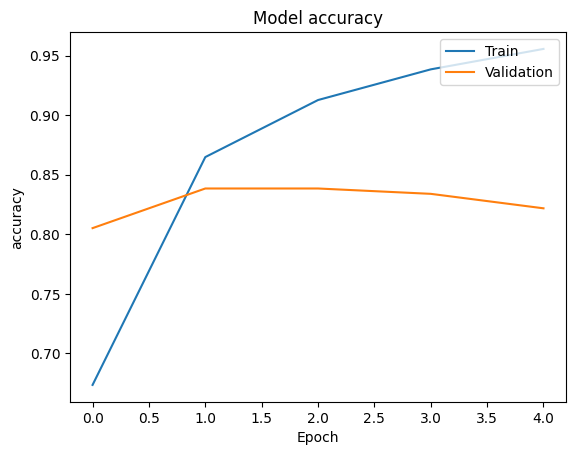

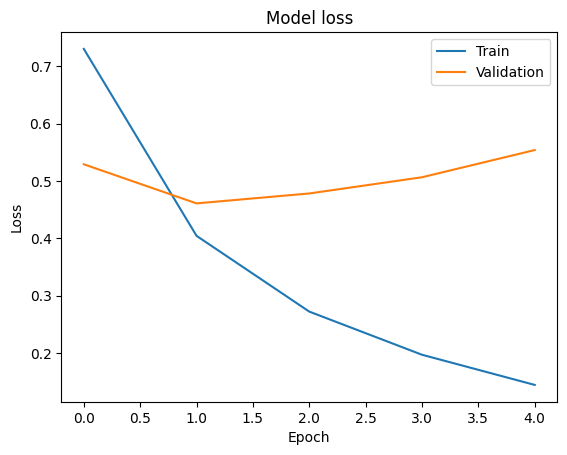

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [63]:
model.save('../Model/sentiment_model.h5')